In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binom, poisson, geom
import math
import matplotlib.pyplot as plt
import timeit
from scipy.stats import linregress
from scipy.special import factorial

class Network ( object ) :
    def __init__ ( self , num_nodes ) :
        self . adj = { i :set () for i in range ( num_nodes ) }

    def add_edge ( self , i , j ) :
        self . adj [ i ]. add ( j )
        self . adj [ j ]. add ( i )

    def neighbors ( self , i ) :
        return self . adj [ i ]

    def edge_list ( self ) :    
        return [( i , j ) for i in self . adj for j in self . adj [ i ] if i < j ]

In [2]:
def generate_edge_list (k):
#n is the number of nodes, k is the degree distribution ( a list where k[i] is)
#the degree of node i)
    n = len ( k )
    S = np.array ([ i for i in range ( n ) for _ in range ( k [ i ]) ])
    S = np.random.permutation ( S )
    if len ( S ) % 2:
        S = S [: -1]
    S = S . reshape ( -1 , 2)
    return S

In [3]:
def to_array(edges):
    if isinstance(edges, list):
        if len(edges) == 0:
            return np.empty((0, 2), dtype=int)
        else:
            return np.array(edges)
    return edges

In [4]:
def generate_H():
    n = 150000
    s = 25000
    k_max = 1000

    #Homogenous network - mean = 6
    k = np.zeros (n, dtype=int)
    for i in range(n):
        k[i] = np.random.geometric(1/7)-1

    k = np.clip(k, None, k_max)

    S = generate_edge_list(k)
    H = Network(n)
    for i, j in S:
            H.add_edge(i, j)
    return H

def generate_I_families(student_mean, interconnections):
    #Control student mean and interconnections, but within non-students: families of 5, each with a mean of 5 edges leaving the family (1/node)
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean+1)
    k_students = np.random.geometric(p, size=s)
    k_students = k_students - 1
    k_students = np.clip(k_students, None, k_max)
    S_edges = generate_edge_list(k_students)

    #family edges
    F_edges = []
    for i in range((n-s)//5):
        parent = i * 5
        family = (parent, parent + 1, parent + 2, parent + 3, parent + 4)
        pairs = list(combinations(family, 2))
        F_edges.extend(pairs)
    F_edges_shifted = [(i + s, j + s) for i, j in F_edges]

    #interfamily edges
    k_non_students = np.random.poisson(1, size=n - s)
    k_non_students = np.clip(k_non_students, None, k_max)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    S_edges = to_array(S_edges)
    N_edges_shifted = to_array(N_edges_shifted)
    F_edges_shifted = to_array(F_edges_shifted)
    inter_edges = to_array(inter_edges)

    all_edges = np.vstack((S_edges, N_edges_shifted, F_edges_shifted, inter_edges)) #- use if allowing interfamily edges
    #all_edges = np.vstack((S_edges, F_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

In [5]:
def generate_I(student_mean, non_student_mean, interconnections):
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean+1)
    k_students = np.random.geometric(p, size=s)
    k_students = k_students -1
    k_students = np.clip(k_students, None, k_max)

    k_non_students = np.random.geometric(1/(non_student_mean+1), size=n - s)
    k_non_students = k_non_students -1
    k_non_students = np.clip(k_non_students, None, k_max)

    S_edges = generate_edge_list(k_students)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    all_edges = np.vstack((S_edges, N_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

In [8]:
def simulation_setup (n, starting_infected):
    #pick starting fraction in I
    p_0 = starting_infected * n

    #randomly pick starting nodes
    I_0 = set()
    for i in range(int(p_0)):
        k = np.random.randint(0, n)
        while k in I_0:
            k = np.random.randint(0, n)
        I_0.add(k)

    R_0 = set()
    D_0 = set()

    S_0 = set()
    for i in range(n):
        if i not in I_0:
            S_0.add(i)

    return S_0, I_0, R_0, D_0

In [6]:
def run_week(S, I, R, D, G, λ, μ, s):
    R_copy = R.copy()
    S_copy = S.copy()
    I_copy = I.copy()
    D_copy = D.copy()


    for i in I:
        for j in G.neighbors(i):
            if j in S_copy:
                if np.random.uniform(0, 1) < λ:
                    S_copy.remove(j)
                    I_copy.add(j)
        if i >= s and np.random.uniform(0, 1) < μ:
            D_copy.add(i)
            I_copy.remove(i)    
        else:
            I_copy.remove(i)
            R_copy.add(i)

    S = S_copy
    I = I_copy
    R = R_copy
    D = D_copy


    return S, I, R, D

def run_simulation (G, I_0, R_0, S_0, D_0, λ, μ, s, weeks):
    Susceptible = []
    Infectious = []
    Recovered = []
    Deceased = []

    Susceptible.append(len(S_0))
    Infectious.append(len(I_0))
    Recovered.append(len(R_0))
    Deceased.append(len(D_0))

    for i in range(weeks):
        S_0, I_0, R_0, D_0 = run_week(S_0, I_0, R_0, D_0, G, λ, μ, s)
        Susceptible.append(len(S_0))
        Infectious.append(len(I_0))
        Recovered.append(len(R_0))
        Deceased.append(len(D_0))

    return Deceased

Comapare two networks
1. Two sub populations, no families. Each non student has mean intraconnectivity = 5
2. Families of 5. Each non student also has mean 1 other connection, so comparable mean intraconnectivity = 5

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


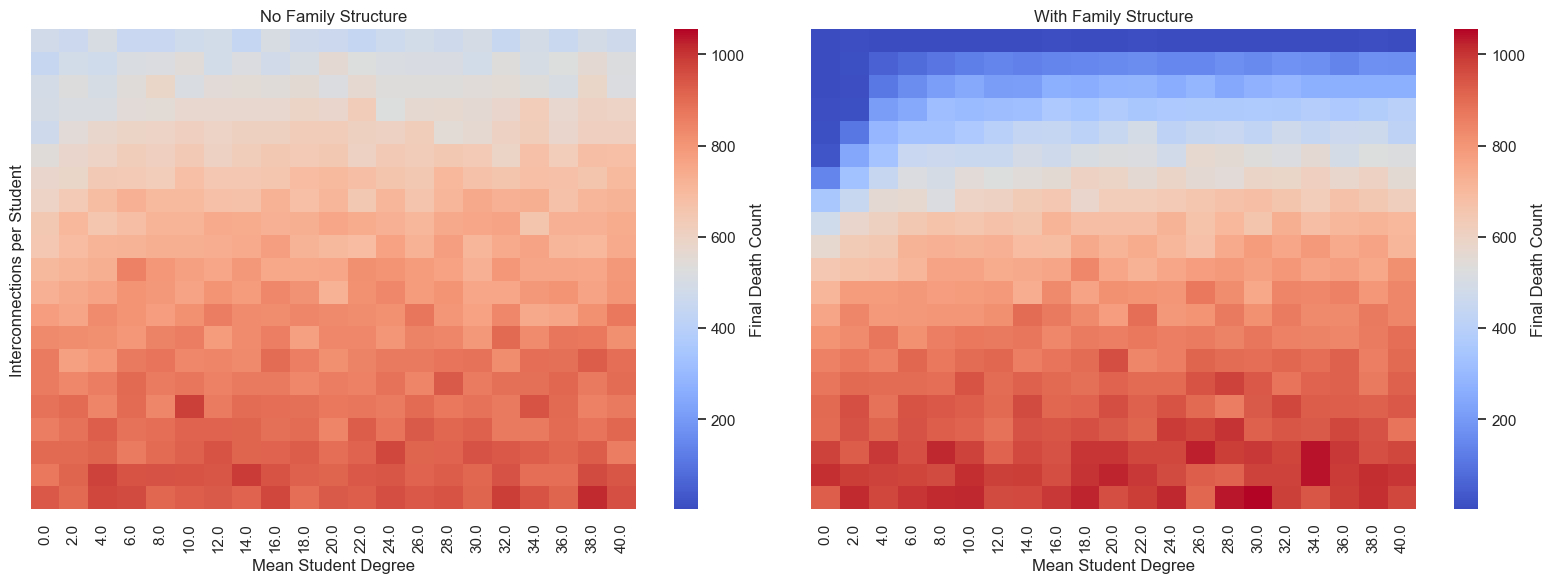

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

n = 150000
λ = 0.2
μ = 0.01
s = 25000
interconnections = np.linspace(0, 20, 21)
weeks = 100
student_means = np.linspace(0, 40, 21)

# Create a 2D array: rows = interconnections, cols = student means
mortality_matrix_nofamilies = np.zeros((len(interconnections), len(student_means)))
mortality_matrix_families = np.zeros((len(interconnections), len(student_means)))

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I = generate_I(m, 5, i)
        S_0, I_0, R_0, D_0 = simulation_setup(n, 0.001)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        mortality_matrix_nofamilies[i_idx, m_idx] = Deceased[-1]

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I_families = generate_I_families(m, i)
        S_0, I_0, R_0, D_0 = simulation_setup(n, 0.001)
        Deceased = run_simulation(I_families, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        mortality_matrix_families[i_idx, m_idx] = Deceased[-1]

# Set plot style
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Set consistent color scale
vmin = min(mortality_matrix_nofamilies.min(), mortality_matrix_families.min())
vmax = max(mortality_matrix_nofamilies.max(), mortality_matrix_families.max())

# Heatmap 1: No family structure
sns.heatmap(
    mortality_matrix_nofamilies,
    ax=axes[0],
    xticklabels=np.round(student_means, 1),
    yticklabels=np.round(interconnections, 1),
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=True,
    cbar_kws={"label": "Final Death Count"}
)
axes[0].set_title("No Family Structure")
axes[0].set_xlabel("Mean Student Degree")
axes[0].set_ylabel("Interconnections per Student")

# Heatmap 2: With families
sns.heatmap(
    mortality_matrix_families,
    ax=axes[1],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # share y-axis
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=True,
    cbar_kws={"label": "Final Death Count"}
)
axes[1].set_title("With Family Structure")
axes[1].set_xlabel("Mean Student Degree")

plt.tight_layout()
plt.show()


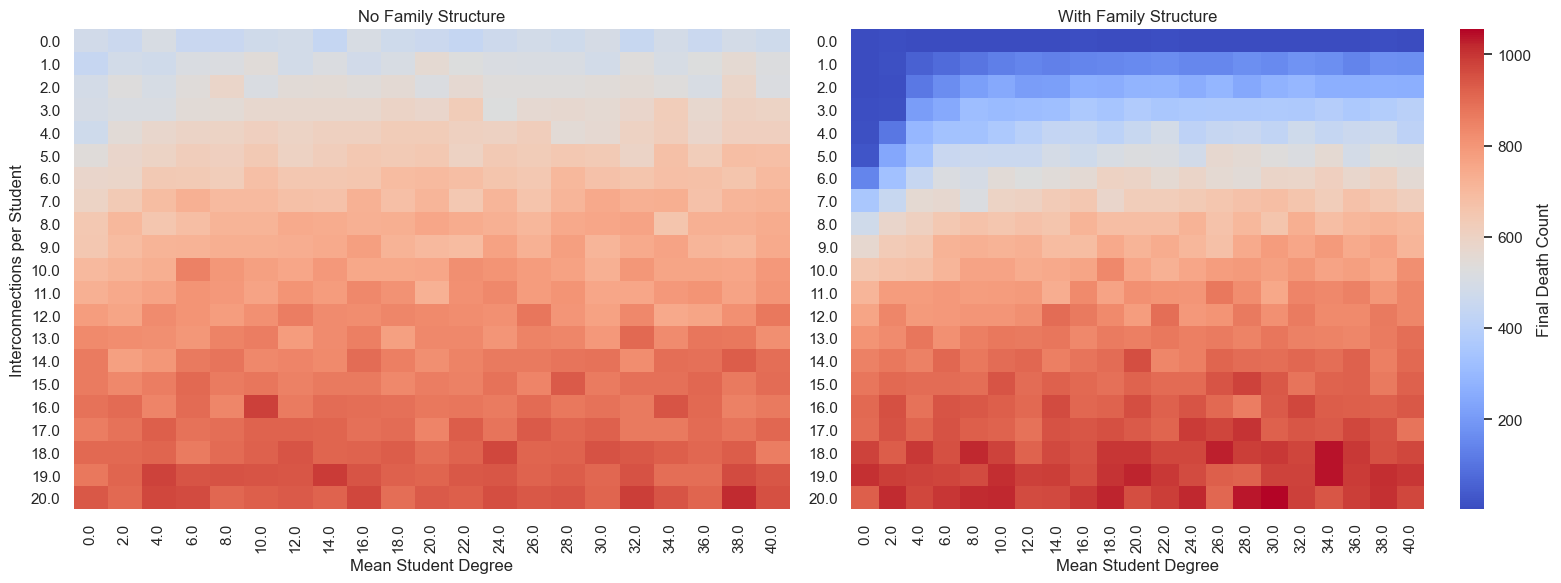

In [38]:
# Set plot style
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Set consistent color scale
vmin = min(mortality_matrix_nofamilies.min(), mortality_matrix_families.min())
vmax = max(mortality_matrix_nofamilies.max(), mortality_matrix_families.max())

# Heatmap 1: No family structure
sns.heatmap(
    mortality_matrix_nofamilies,
    ax=axes[0],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # Let us control y-ticks manually
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=False,
    #cbar_kws={"label": "Final Death Count"}
)

# Heatmap 2: With families
sns.heatmap(
    mortality_matrix_families,
    ax=axes[1],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # Same here — we will set manually
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=True,
    cbar_kws={"label": "Final Death Count"}
)

# Manually set y-tick labels
yticks = np.arange(len(interconnections)) + 0.5  # Heatmap centers
yticklabels = np.round(interconnections, 1)

for ax in axes:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.tick_params(labelleft=True)  # Force showing y-tick labels

# Titles and labels
axes[0].set_title("No Family Structure")
axes[0].set_xlabel("Mean Student Degree")
axes[0].set_ylabel("Interconnections per Student")

axes[1].set_title("With Family Structure")
axes[1].set_xlabel("Mean Student Degree")

plt.tight_layout()
plt.show()


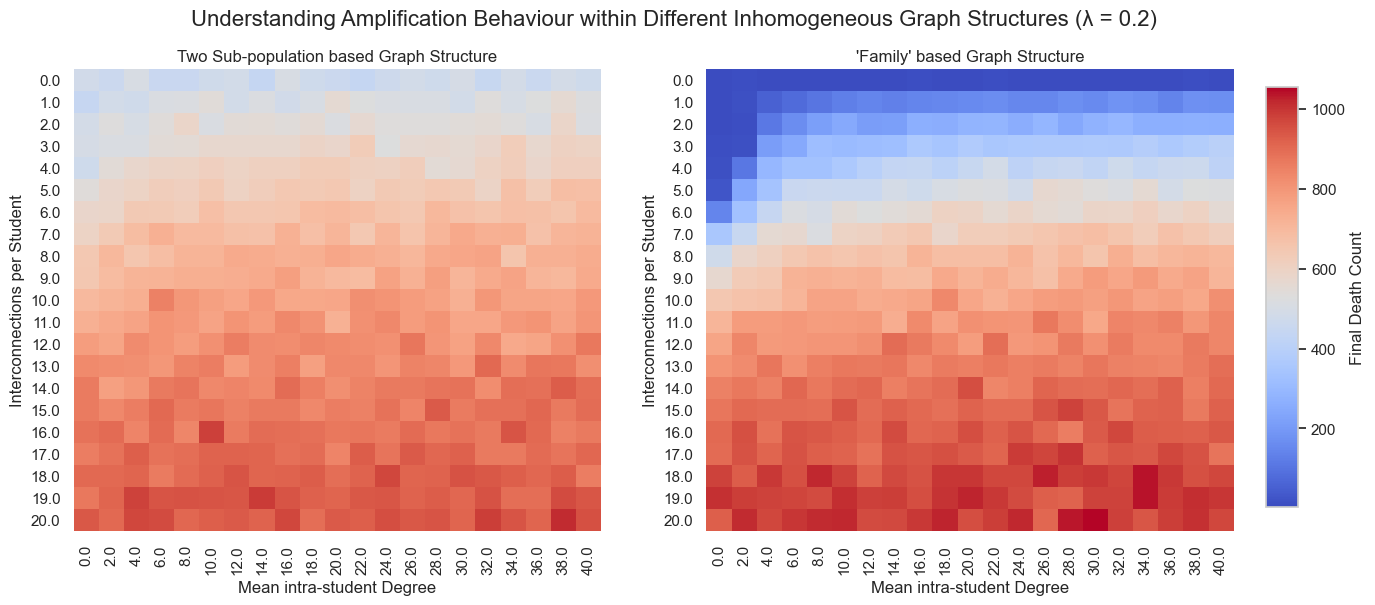

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Set consistent color scale across both heatmaps
vmin = min(mortality_matrix_nofamilies.min(), mortality_matrix_families.min())
vmax = max(mortality_matrix_nofamilies.max(), mortality_matrix_families.max())

# Heatmap 1: No family structure (no colorbar)
im0 = sns.heatmap(
    mortality_matrix_nofamilies,
    ax=axes[0],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # We'll set manually
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=False
)

# Heatmap 2: With family structure (also no colorbar here)
im1 = sns.heatmap(
    mortality_matrix_families,
    ax=axes[1],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # We'll set manually
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=False
)

# Manually set y-tick labels on both axes
yticks = np.arange(len(interconnections)) + 0.5  # Center of heatmap cells
yticklabels = np.round(interconnections, 1)

for ax in axes:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.tick_params(labelleft=True)

# Set titles and axis labels
axes[0].set_title("Two Sub-population based Graph Structure")
axes[0].set_xlabel("Mean intra-student Degree")
axes[0].set_ylabel("Interconnections per Student")

axes[1].set_title("'Family' based Graph Structure")
axes[1].set_xlabel("Mean intra-student Degree")
axes[1].set_ylabel("Interconnections per Student")

# Adjust layout and add shared colorbar to the right
fig.subplots_adjust(right=0.85)  # Create space on the right
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1.get_children()[0], cax=cbar_ax, label="Final Death Count")

fig.suptitle("Understanding Amplification Behaviour within Different Inhomogeneous Graph Structures (λ = 0.2)", fontsize=16)

plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

n = 150000
λ = 0.05
μ = 0.01
s = 25000
interconnections = np.linspace(0, 20, 21)
weeks = 100
student_means = np.linspace(0, 40, 21)

# Create a 2D array: rows = interconnections, cols = student means
mortality_matrix_nofamilies = np.zeros((len(interconnections), len(student_means)))
mortality_matrix_families = np.zeros((len(interconnections), len(student_means)))

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I = generate_I(m, 5, i)
        S_0, I_0, R_0, D_0 = simulation_setup(n, 0.001)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        mortality_matrix_nofamilies[i_idx, m_idx] = Deceased[-1]

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I_families = generate_I_families(m, i)
        S_0, I_0, R_0, D_0 = simulation_setup(n, 0.001)
        Deceased = run_simulation(I_families, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        mortality_matrix_families[i_idx, m_idx] = Deceased[-1]



0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


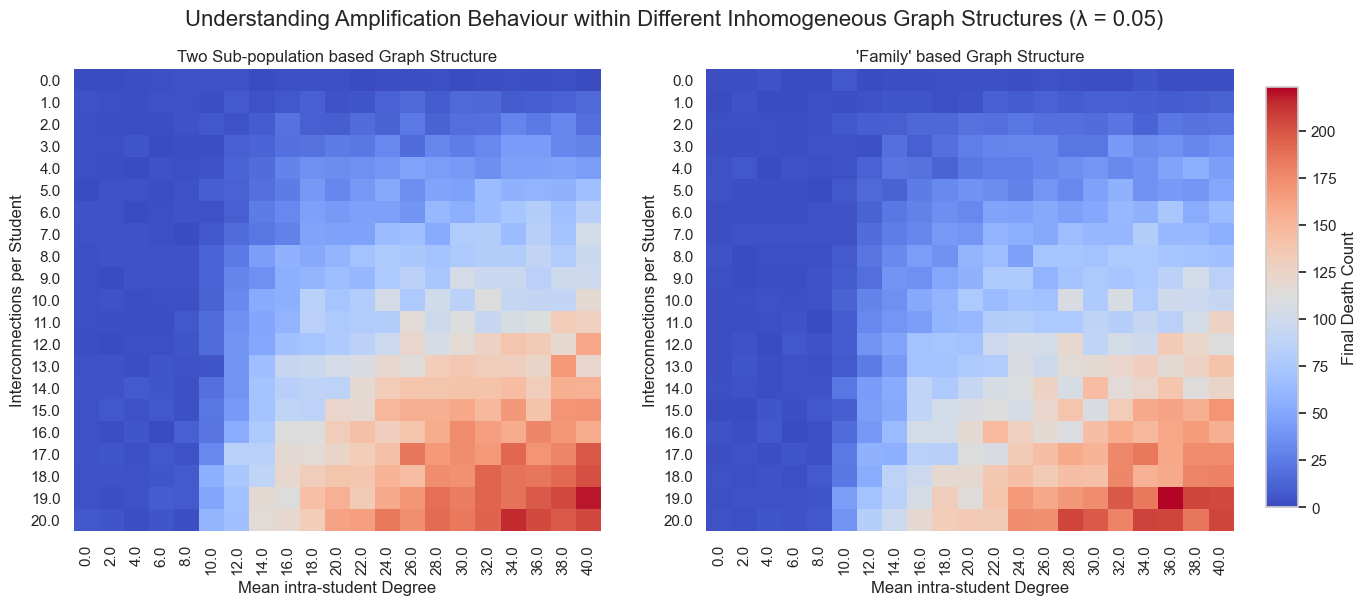

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Set consistent color scale across both heatmaps
vmin = min(mortality_matrix_nofamilies.min(), mortality_matrix_families.min())
vmax = max(mortality_matrix_nofamilies.max(), mortality_matrix_families.max())

# Heatmap 1: No family structure (no colorbar)
im0 = sns.heatmap(
    mortality_matrix_nofamilies,
    ax=axes[0],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # We'll set manually
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=False
)

# Heatmap 2: With family structure (also no colorbar here)
im1 = sns.heatmap(
    mortality_matrix_families,
    ax=axes[1],
    xticklabels=np.round(student_means, 1),
    yticklabels=False,  # We'll set manually
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar=False
)

# Manually set y-tick labels on both axes
yticks = np.arange(len(interconnections)) + 0.5  # Center of heatmap cells
yticklabels = np.round(interconnections, 1)

for ax in axes:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.tick_params(labelleft=True)

# Set titles and axis labels
axes[0].set_title("Two Sub-population based Graph Structure")
axes[0].set_xlabel("Mean intra-student Degree")
axes[0].set_ylabel("Interconnections per Student")

axes[1].set_title("'Family' based Graph Structure")
axes[1].set_xlabel("Mean intra-student Degree")
axes[1].set_ylabel("Interconnections per Student")

# Adjust layout and add shared colorbar to the right
fig.subplots_adjust(right=0.85)  # Create space on the right
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1.get_children()[0], cax=cbar_ax, label="Final Death Count")

fig.suptitle("Understanding Amplification Behaviour within Different Inhomogeneous Graph Structures (λ = 0.05)", fontsize=16)

plt.show()
